In [2]:
#################################################
################  Import things #################
#################################################

import numpy as np
import timeit
import random
import copy
import matplotlib.pyplot as plt
from sklearn import datasets
import pickle
from scipy import stats
import glycowork
import pandas as pd


from scipy.stats import dirichlet
import dirichlet as dirichlet_mle #https://github.com/ericsuh/dirichlet

from glycowork.glycan_data.loader import glycan_binding as gb
from glycowork.glycan_data.loader import df_glycan as df_glycan
from glycowork.glycan_data.loader import glycomics_data_loader

In [6]:
from typing import Any, Dict, List, Optional, Tuple, Union
from pathlib import Path
from sklearn.manifold import TSNE

def get_embeddings(
   glycans: List[str], # List of IUPAC-condensed glycan sequences
   emb: Optional[Union[Dict[str, np.ndarray], pd.DataFrame]] = None, # Glycan embeddings dict/DataFrame; defaults to SweetNet embeddings
   label_list: Optional[List[Any]] = None, # Labels for coloring points
   shape_feature: Optional[str] = None, # Monosaccharide/bond for point shapes
   filepath: Union[str, Path] = '', # Path to save plot
   alpha: float = 0.8, # Point transparency
   palette: str = 'colorblind', # Color palette for groups
   **kwargs: Any # Keyword args passed to seaborn scatterplot
   ) -> None:
    "Visualizes learned glycan embeddings using t-SNE dimensionality reduction with optional group coloring"
    idx = [i for i, g in enumerate(glycans) if '{' not in g]
    glycans = [glycans[i] for i in idx]
    if label_list is not None:
      label_list = [label_list[i] for i in idx]
    # Get all glycan embeddings
    if emb is None:
      if not Path('glycan_representations_v1_4.pkl').exists():
          download_model("https://drive.google.com/file/d/1--tf0kyea9jFLfffUtICKkyIw36E9hJ3/view?usp=sharing", local_path = 'glycan_representations_v1_4.pkl')
      emb = pickle.load(open('glycan_representations_v1_4.pkl', 'rb'))
    # Get the subset of embeddings corresponding to 'glycans'
    if isinstance(emb, pd.DataFrame):
      embs = emb.values
      glycans_used = glycans
    else:
      glycans_used = [g for g in glycans if g in emb]
      embs = np.vstack([emb[g] for g in glycans_used])
    # # Calculate t-SNE of embeddings
    # n_samples = embs.shape[0]
    # perplexity = min(30, n_samples - 1)
    # embs = TSNE(random_state = 42, perplexity = perplexity,
    #             init = 'pca', learning_rate = 'auto').fit_transform(embs)
    return embs, glycans_used

def get_affinity_relative(glycan, prot_row, emb, threshold = 0.5, force_nearest = False, no_nan = False):
    # Step 1: If the glycan is in the reference set and we are not forcing nearest neighbor search,
    #         return the glycan itself and True (indicating a direct match).
    if (glycan in glycans_in_gb) and (not force_nearest) and ((not no_nan) or (not np.isnan(prot_row[glycan].to_numpy()[0]))):
        return glycan, True
    else:
        if glycan not in emb:
            return None, False
        # Step 2: Otherwise, get the embedding vector for the input glycan.
        embedding = np.array(emb[glycan])
        # Step 3: Initialize variables to track the minimum distance and the closest glycan found so far.
        min_dist = float('inf')
        closest_glycan = None
        # Step 4: Iterate over all glycans in the reference set that have embeddings.
        for g in glycans_in_gb_and_emb:
            # Step 5: If not forcing nearest, skip the input glycan itself.
            if g != glycan or not force_nearest:
                # Step 6: Compute the Euclidean distance between the input glycan and the current glycan.
                dist = np.linalg.norm(embedding - np.array(emb[g]))
                # Step 7: If this is the smallest distance so far, and (optionally) the protein row is not NaN,
                #         update the closest glycan and minimum distance.
                if dist < min_dist:
                    if not no_nan or not np.isnan(prot_row[g].to_numpy()[0]):
                        min_dist = dist
                        closest_glycan = g
        # Step 8: Return the closest glycan and whether its distance is below the threshold.
        return closest_glycan, min_dist < threshold
    
    
def get_nearest_affinity(glycan, prot_row, emb, threshold = 0.5, force_nearest = False, no_nan = False):
    aff_gly, is_close = get_affinity_relative(glycan, prot_row, emb, threshold, force_nearest, no_nan)
    if is_close:
        aff = prot_row[aff_gly].to_numpy()[0]
    else:
        aff = np.nan
    return aff, aff_gly==glycan

def get_affinity(glycan, prot_row):
    if glycan in prot_row.columns:
        return prot_row[glycan].to_numpy()[0]
    else:
        print("not in prot_row")
        return np.nan

def prob_dist(vals):
    vals_new = vals + 1e-8
    return vals_new / np.sum(vals_new)
    
glycans_in_gb = list(gb.columns)
emb = pickle.load(open('glycan_representations_v1_4.pkl', 'rb'))
embs, glycans_in_gb_and_emb = get_embeddings(glycans_in_gb)
emb_dict = dict(zip(glycans_in_gb_and_emb, embs))

In [4]:
# Get all dataset names (strings)
datasets = dir(glycomics_data_loader)

# Optional: filter out private/internal attributes
datasets = [name for name in datasets if not name.startswith('_')]

# Loop through each dataset
for name in datasets:
    # Get the DataFrame object from the loader
    df = getattr(glycomics_data_loader, name)

    print(name)
    print(len(df.columns))
    print(df.columns)


HIV_gagtransfection_N_PMID35112714
13
Index(['glycan', 'nontransfected_1', 'nontransfected_2', 'nontransfected_3',
       'nontransfected_4', 'mocktransfected_1', 'mocktransfected_2',
       'mocktransfected_3', 'mocktransfected_4', 'gagtransfected_1',
       'gagtransfected_2', 'gagtransfected_3', 'gagtransfected_4'],
      dtype='object')
HIV_gagtransfection_O_PMID35112714
13
Index(['glycan', 'nontransfected_1', 'nontransfected_2', 'nontransfected_3',
       'nontransfected_4', 'mocktransfected_1', 'mocktransfected_2',
       'mocktransfected_3', 'mocktransfected_4', 'gagtransfected_1',
       'gagtransfected_2', 'gagtransfected_3', 'gagtransfected_4'],
      dtype='object')
human_brain_GSL_PMID38343116
11
Index(['glycan', 'GSL_Control_1', 'GSL_Control_2', 'GSL_Control_3',
       'GSL_Control_4', 'GSL_SSSMuG_1', 'GSL_SSSMuG_2', 'GSL_SSSMuG_3',
       'GSL_SSSMuG_4', 'GSL_SSSMuG_5', 'GSL_SSSMuG_6'],
      dtype='object')
human_brain_N_PMID38343116
11
Index(['glycan', 'NG_Control_1', '

In [7]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def get_group_indices(df, groups):
    """
    Given a DataFrame and a list of group names, return a dict mapping each group to a list of column names containing that group string.
    """
    group_indices = dict(zip(groups, [[] for _ in groups]))
    for col in df.columns:
        for group in groups:
            if group in col:
                group_indices[group].append(col)
    return group_indices

def build_prot_seq_list(prot_names):
    prot_seq_list = []
    for prot_name in prot_names:
        prot_seq_list.append(gb[gb['protein'] == prot_name]['target'].iloc[0])
    return prot_seq_list

def build_z_score_mat(glycans_in_df, prot_seq_list, emb, use_emb = True, force_nearest = False, no_nan = True):
    n_gly = len(glycans_in_df)
    n_prots = len(prot_seq_list)
    z_score_mat = np.zeros((n_prots, n_gly))

    for (p, prot_seq) in enumerate(prot_seq_list):
        prot_row = gb[gb['target'] == prot_seq]
        for (i, gly) in enumerate(glycans_in_df):
            if use_emb:
                aff, is_glycan = get_nearest_affinity(gly, prot_row, emb, 1, force_nearest, no_nan)
                # if not is_glycan:
                #     print(gly, aff)
            else:
                if gly in prot_row.columns:
                    gly_ind = glycans_in_df.index(gly)
                    aff = prot_row[gly].to_numpy()[0]
                else:
                    aff = np.nan
            z_score_mat[p, i] = 0 if np.isnan(aff) else aff
    return z_score_mat

def build_random_z_score_mat(glycans_in_df, n_prots, random_func=np.random.normal, **random_kwargs):
    n_gly = len(glycans_in_df)
    z_score_mat = random_func(size=(n_prots, n_gly), **random_kwargs)
    return z_score_mat

def build_activation_arrays(z_score_mat, group_indices, df):
    aff_mat = z_score_mat
    activation_arrays = {}
    for group, col_list in group_indices.items():
        activation_array = np.zeros((aff_mat.shape[0], len(col_list)))
        for i, col in enumerate(col_list):
            glycan_dist = prob_dist(np.array(df[col]))
            activation_array[:, i] = np.dot(aff_mat, glycan_dist)
        activation_arrays[group] = activation_array
    return activation_arrays


def build_distribution_arrays(group_indices, df):
    distribution_arrays = {}
    for group, col_list in group_indices.items():
        distribution_array = np.zeros((df.shape[0], len(col_list)))
        for i, col in enumerate(col_list):
            glycan_dist = prob_dist(np.array(df[col]))
            distribution_array[:, i] = glycan_dist
        distribution_arrays[group] = distribution_array
    return distribution_arrays

def pca_distribution_arrays(distribution_arrays, n_components=2):
    all_samples = []
    group_sample_counts = {}
    for group, arr in distribution_arrays.items():
        arr = np.asarray(arr)
        all_samples.append(arr.T)  # shape: (samples, features)
        group_sample_counts[group] = arr.shape[1]
    all_samples = np.vstack(all_samples)  # shape: (total_samples, features)

    # Fit PCA on all samples
    pca = PCA(n_components=n_components)
    all_samples_pca = pca.fit_transform(all_samples)

    # Split back into groups
    pca_arrays = {}
    start = 0
    for group, count in group_sample_counts.items():
        end = start + count
        # Transpose back to (n_components, samples_in_group)
        pca_arrays[group] = all_samples_pca[start:end].T
        start = end
    return pca_arrays

def tsne_distribution_arrays(distribution_arrays, n_components=2, random_state=None, **tsne_kwargs):
    method = tsne_kwargs.get('method', 'barnes_hut')
    if n_components >= 4 and method == 'barnes_hut':
        method = 'exact'
    tsne_kwargs['method'] = method
    # Stack all samples from all groups for fitting t-SNE
    all_samples = []
    group_sample_counts = {}
    for group, arr in distribution_arrays.items():
        arr = np.asarray(arr)
        all_samples.append(arr.T)  # shape: (samples, features)
        group_sample_counts[group] = arr.shape[1]
    all_samples = np.vstack(all_samples)  # shape: (total_samples, features)

    # Fit t-SNE on all samples
    tsne = TSNE(n_components=n_components, random_state=random_state, **tsne_kwargs)
    all_samples_tsne = tsne.fit_transform(all_samples)

    # Split back into groups
    tsne_arrays = {}
    start = 0
    for group, count in group_sample_counts.items():
        end = start + count
        # Transpose back to (n_components, samples_in_group)
        tsne_arrays[group] = all_samples_tsne[start:end].T
        start = end
    return tsne_arrays

def compute_silhouette_score(activation_arrays):
    # Suppose activation_arrays is your dict as above
    X = []      # List to hold all activation vectors (samples)
    labels = [] # List to hold group labels for each sample

    for group, arr in activation_arrays.items():
        # arr shape: (n_proteins, n_samples_in_group)
        arr = np.asarray(arr)
        X.append(arr.T)  # Transpose so each row is a sample
        labels.extend([group] * arr.shape[1])

    X = np.vstack(X)  # Shape: (total_samples, n_proteins)
    labels = np.array(labels)

    score = silhouette_score(X, labels)
    return score

def sample_proteins_and_get_silhouette_score(n_proteins, glycans_in_df, emb, group_indices, df):

    prot_inds = np.random.choice(range(len(gb)), n_proteins, replace=False)
    prot_names = gb['protein'].iloc[prot_inds]
    prot_seq_list = build_prot_seq_list(prot_names)
    z_score_mat = build_z_score_mat(glycans_in_df, prot_seq_list, emb, use_emb = True, force_nearest = False, no_nan = True)
    activation_arrays = build_activation_arrays(z_score_mat, group_indices, df)
    distribution_arrays = build_distribution_arrays(group_indices, df)
    return compute_silhouette_score(activation_arrays), compute_silhouette_score(distribution_arrays), prot_names

def sample_random_matrix_and_get_silhouette_score(n_proteins, glycans_in_df, group_indices, df, random_func=np.random.normal, **random_kwargs):

    z_score_mat = build_random_z_score_mat(glycans_in_df, n_proteins, random_func, **random_kwargs)
    activation_arrays = build_activation_arrays(z_score_mat, group_indices, df)
    return compute_silhouette_score(activation_arrays), z_score_mat



def fit_dirichlet_distribution(df, group_indices, lambda_val = 1):
    group_alphas = {}
    n_glys = df.shape[0]
    for group in group_indices:
        alphas = np.zeros(n_glys)
        for i, g in enumerate(group_indices[group]):
            glycan_dist = prob_dist(np.array(df[g]))
            alphas += glycan_dist / len(group_indices[group])
        group_alphas[group] = lambda_val * alphas
    return group_alphas

def fit_dirichlet_distribution_mle(df, group_indices):
    group_alphas = {}
    n_glys = df.shape[0]
    for group in group_indices:
        dists = np.zeros((len(group_indices[group]), n_glys))
        for i, g in enumerate(group_indices[group]):
            glycan_dist = prob_dist(np.array(df[g]))
            dists[i,:] = glycan_dist
        alphas = dirichlet_mle.mle(dists, method="fixedpoint")
        group_alphas[group] = alphas
    return group_alphas

def build_activation_arrays_with_sampling(z_score_mat, group_indices, df, n_samples, lambda_val = 20):
    group_alphas = fit_dirichlet_distribution(df, group_indices, lambda_val)
    aff_mat = z_score_mat
    activation_arrays = {}
    for group in group_indices:
        activation_array = np.zeros((aff_mat.shape[0], n_samples))
        for i in range(n_samples):
            samp = dirichlet.rvs(group_alphas[group], size = 1)[0]
            activation_array[:, i] = np.dot(aff_mat, samp)
        activation_arrays[group] = activation_array
    return activation_arrays

def build_activation_arrays_with_sampling_mle(z_score_mat, group_indices, df, n_samples):
    group_alphas = fit_dirichlet_distribution_mle(df, group_indices)
    aff_mat = z_score_mat
    activation_arrays = {}
    for group in group_indices:
        activation_array = np.zeros((aff_mat.shape[0], n_samples))
        for i in range(n_samples):
            samp = dirichlet.rvs(group_alphas[group], size = 1)[0]
            activation_array[:, i] = np.dot(aff_mat, samp)
        activation_arrays[group] = activation_array
    return activation_arrays 


def get_activation_extrema(activation_arrays):
    """Get min/max values across all activation arrays"""
    xmin, xmax = float('inf'), float('-inf')
    ymin, ymax = float('inf'), float('-inf')
    
    for group, activation_array in activation_arrays.items():
        x = activation_array[0,:]
        y = activation_array[1,:]
        
        xmin = min(xmin, x.min())
        xmax = max(xmax, x.max()) 
        ymin = min(ymin, y.min())
        ymax = max(ymax, y.max())
        
    return xmin, xmax, ymin, ymax


17
[True, True, True, True, False, False, True, False, True, False, False, False, False, False, False, False, False]
[True, True, True, True, False, False, True, False, True, True, False, False, True, True, True, True, True]
stage1_1


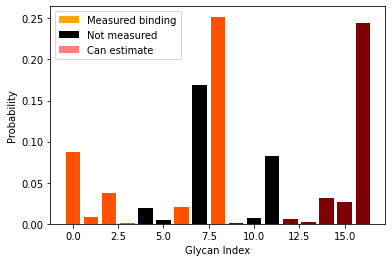

In [35]:
df = glycomics_data_loader.human_serum_bacteremia_N_PMID33535571
groups = ['EC', 'PA', 'SA', 'SV', 'HV']

# df = glycomics_data_loader.human_skin_O_PMC5871710 # can also use human_skin_O_PMC5871710 and _BCC
# groups = ['control', 'tumor']

df = glycomics_data_loader.human_prostate_O_PMC8010466
groups = ['control', 'stage1', 'stage2', 'stage3', 'stage4', 'stage5']



# for gly in glycans_in_df:
#     if '{' in gly:
#         print(gly)

group_indices = get_group_indices(df, groups)
glycans_in_df = list(df['glycan'])

print(len(glycans_in_df))

glycan_mask = [gly in gb.columns for gly in glycans_in_df]
glycan_mask_emb = [gly in emb.keys() for gly in glycans_in_df]

print(glycan_mask)
print(glycan_mask_emb)


# groupEC_list = group_indices['EC']
# groupPA_list = group_indices['PA']
# groupSA_list = group_indices['SA']
# groupSV_list = group_indices['SV']
# groupHV_list = group_indices['HV']
# print(groupEC_list)

g = group_indices[groups[1]][0]

print(g)
glycan_dist = prob_dist(np.array(df[g]))
plt.bar([i for i in range(len(glycan_dist)) if glycan_mask[i]], [glycan_dist[i] for i in range(len(glycan_dist)) if glycan_mask[i]], color='orange', alpha=1, label='Measured binding') # False is blue
plt.bar([i for i in range(len(glycan_dist)) if not glycan_mask[i]], [glycan_dist[i] for i in range(len(glycan_dist)) if not glycan_mask[i]], color='black', alpha=1, label='Not measured') # False is blue
plt.bar([i for i in range(len(glycan_dist)) if glycan_mask_emb[i]], [glycan_dist[i] for i in range(len(glycan_dist)) if glycan_mask_emb[i]], color='red', alpha=0.5, label='Can estimate') # False is blue
plt.xlabel('Glycan Index')
plt.ylabel('Probability')
plt.legend()
#plt.scatter(range(len(glycan_dist)), glycan_dist, c=glycan_mask_emb, cmap='bwr', alpha=1) # False is blue


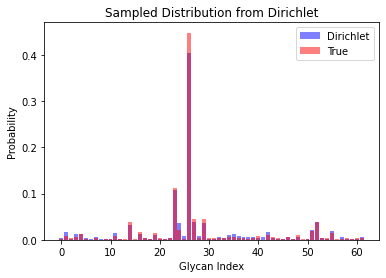

In [21]:

group_alphas = fit_dirichlet_distribution_mle(df, group_indices)

# true = prob_dist(np.array(df[group_indices['EC'][0]]))
# samp = dirichlet.rvs(group_alphas['EC'], size = 1)[0] 

true = prob_dist(np.array(df[group_indices['EC'][0]]))
samp = dirichlet.rvs(group_alphas['EC'], size = 1)[0] 

plt.figure()
plt.bar(np.array(range(len(samp))), samp, color = 'blue', alpha = 0.5, label = 'Dirichlet')
plt.bar(np.array(range(len(true)))+0.0, true, color = 'red', alpha = 0.5, label = 'True')
plt.xlabel('Glycan Index')
plt.ylabel('Probability')
plt.title('Sampled Distribution from Dirichlet')
plt.legend()



In [10]:
prot_1 = "ConA"
prot_2 = "WGA"


# p_ind_1 = 33
# p_ind_2 = 40
# prot_1 = gb['protein'].iloc[33]
# prot_2 = gb['protein'].iloc[40]


prot_names = [prot_1, prot_2]
print(prot_names)
prot_seq_list = build_prot_seq_list(prot_names)




['ConA', 'WGA']


In [210]:
ss_act, ss_dist, prot_names = sample_proteins_and_get_silhouette_score(20, glycans_in_df, emb, group_indices, df)
print(ss_act, ss_dist)

0.00385775173866822 0.031136232896101214


In [237]:
distribution_arrays = build_distribution_arrays(group_indices, df)
pca_arrays = pca_distribution_arrays(distribution_arrays, n_components=5)
tsne_arrays = tsne_distribution_arrays(distribution_arrays, n_components=5, perplexity=12)
ss_pca = compute_silhouette_score(pca_arrays)
ss_tsne = compute_silhouette_score(tsne_arrays)
ss_dict = compute_silhouette_score(distribution_arrays)
print(ss_pca)
print(ss_tsne)
print(ss_dict)


0.2240222520908835
-0.012387175
0.21912170465195105


1215    Tp0751
229      AstV8
Name: protein, dtype: object
-0.10292202505516228


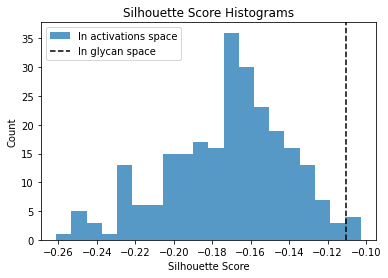

In [36]:
ss_act_list = []
ss_dist_list = []
ss_act_z_list = []
max_ss_act = -float('inf')
max_ss_act_z = -float('inf')
prot_names_with_scores = []  # List of (score, names) tuples
for _ in range(250):
    try:
        ss_act, ss_dist, prot_names = sample_proteins_and_get_silhouette_score(2, glycans_in_df, emb, group_indices, df)
    except:
        continue
    prot_names_with_scores.append((ss_act, prot_names))
    ss_act_list.append(ss_act)
    ss_dist_list.append(ss_dist)

    # ss_act_z, z_matrix = sample_random_matrix_and_get_silhouette_score(2, glycans_in_df, group_indices, df, random_func=np.random.poisson)
    # ss_act_z_list.append(ss_act_z)
    # if ss_act_z > max_ss_act_z:
    #     max_ss_act_z = ss_act_z
    #     max_z_matrix = z_matrix  # Assuming z_matrix is returned from sample_random_matrix_and_get_silhouette_score

# Sort by score in descending order
prot_names_with_scores.sort(reverse=True)
max_ss_act = prot_names_with_scores[0][0]
max_ss_act_prot_names = prot_names_with_scores[0][1]



print(max_ss_act_prot_names)
print(max_ss_act)
plt.hist(ss_act_list, bins=20, alpha=0.75, label='In activations space')
plt.axvline(x=np.mean(ss_dist_list), color='black', linestyle='--', label='In glycan space')
#plt.hist(ss_act_z_list, bins=20, alpha=0.5, label='Distribution Z')
plt.xlabel('Silhouette Score')
plt.ylabel('Count')
plt.title('Silhouette Score Histograms')
plt.legend()
plt.show()


In [194]:
prot_names_with_scores

[(0.13710286229945154,
  837    A/Puerto Rico/8/1934/CV10(H1N1)
  18                               A/H12
  Name: protein, dtype: object),
 (0.24069239333459785,
  336     LPA
  1324    AAL
  Name: protein, dtype: object),
 (0.26096533419724444,
  969    Siglec-E
  527         APP
  Name: protein, dtype: object),
 (0.029926092694790032,
  835     A/Puerto Rico/8/1934/WV7(H1N1)
  1207                              SAG1
  Name: protein, dtype: object),
 (0.30673277612027516,
  994                  RegIIIgamma
  549    A/Vietnam/1203/2004(H5N1)
  Name: protein, dtype: object),
 (0.030273185566084444,
  390            CPA
  1228    SspB A3vp1
  Name: protein, dtype: object),
 (0.01643282841843352,
  416                          Crocus Lectin
  511    A/Shorebird/Delaware/300/2009(H1N1)
  Name: protein, dtype: object),
 (0.04056481140844239,
  511    A/Shorebird/Delaware/300/2009(H1N1)
  578              A/Vietnam/1194/2004(H5N1)
  Name: protein, dtype: object),
 (0.24942188664131404,
  604  

In [41]:
prot_1 = "ConA"
prot_2 = "WGA"
# prot_1 = "Si Bti9 1b-V5-his"
# prot_2 = "Epa13"

p_ind_1 = 33
p_ind_2 = 40
prot_1 = gb['protein'].iloc[33]
prot_2 = gb['protein'].iloc[40]


prot_names = [prot_1, prot_2]
print(prot_names)
prot_seq_list = build_prot_seq_list(prot_names)

['DGL', 'Mannose Binding Protein']


-0.15398949809141127
-0.11028606068998396
-0.10292202505516228


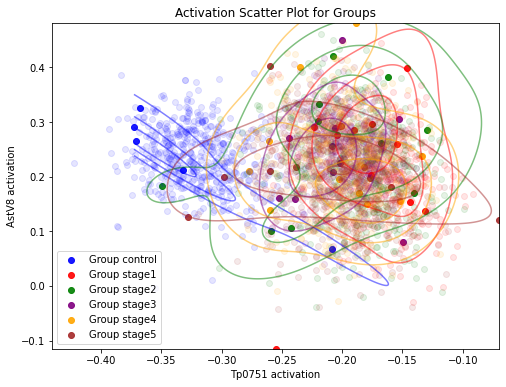

In [46]:
from sklearn.metrics import silhouette_score
from scipy.stats import gaussian_kde


max_ss_act_prot_names = prot_names_with_scores[0][1]

prot_names = max_ss_act_prot_names.to_list()
#prot_names = [prot_1, prot_2]


prot_seq_list = build_prot_seq_list(prot_names)

z_score_mat = build_z_score_mat(glycans_in_df, prot_seq_list, emb, use_emb = True, force_nearest = False, no_nan = True)

# z_score_mat = max_z_matrix
activation_arrays = build_activation_arrays(z_score_mat, group_indices, df)

#activation_arrays = build_activation_arrays_with_sampling(z_score_mat, group_indices, df, 500, 2000)
activation_arrays_sample = build_activation_arrays_with_sampling_mle(z_score_mat, group_indices, df, 500)


# # Create heatmap
# plt.figure(figsize=(10, 6))
# plt.imshow(z_score_mat, aspect='auto', cmap='RdBu_r')
# plt.colorbar(label='Z-score')

# # Add labels
# plt.xlabel('Glycans')
# plt.ylabel('Proteins')
# plt.title('Protein-Glycan Binding Z-scores')

# # Add protein labels
# plt.yticks([0, 1], ['ConA', 'WGA'])

# # Rotate x-axis labels for readability if needed
# plt.xticks(range(len(glycans_in_df)), glycans_in_df, rotation=45, ha='right')

# plt.tight_layout()
# plt.show()

distribution_arrays = build_distribution_arrays(group_indices, df)
pca_arrays = pca_distribution_arrays(distribution_arrays, n_components=2)
ss_pca = compute_silhouette_score(pca_arrays)
ss_dict = compute_silhouette_score(distribution_arrays)
ss_act = compute_silhouette_score(activation_arrays)
print(ss_pca)
print(ss_dict)
print(ss_act)

# Plot scatter plots for both groups
plt.figure(figsize=(8, 6))
# Plot scatter plots for all groups in activation_arrays
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed

    
# for i, (group, activation_array) in enumerate(pca_arrays.items()):
#     plt.scatter(activation_array[0,:], activation_array[1,:], #label=f'Group {group}',
#                 color=colors[i], alpha=0.9)
    


for i, (group, activation_array) in enumerate(activation_arrays.items()):
    plt.scatter(activation_array[0,:], activation_array[1,:], 
                color=colors[i], label=f'Group {group}', alpha=0.9)
    


for i, (group, activation_array) in enumerate(activation_arrays_sample.items()):
    plt.scatter(activation_array[0,:], activation_array[1,:], #label=f'Group {group}',
                color=colors[i], alpha=0.1)

for i, (group, activation_array) in enumerate(activation_arrays.items()):
    # Calculate the kernel density estimate
    x = activation_array[0,:]
    y = activation_array[1,:]
    
    # Create a 2D histogram first to determine range
    xmin, xmax, ymin, ymax = get_activation_extrema(activation_arrays)
    
    # Create grid of points
    xx, yy = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    # Perform kernel density estimation
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    z = np.reshape(kernel(positions).T, xx.shape)
    
    # Plot contours
    plt.contour(xx, yy, z, levels=3, colors=colors[i], alpha=0.5)
    #plt.contourf(xx, yy, z, levels=5, colors=[colors[i]], alpha=0.2)

plt.title('KDE Contour Plot of Activation Distributions')

    
# Labels and legend
plt.xlabel(f'{prot_names[0]} activation')
plt.ylabel(f'{prot_names[1]} activation')
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
plt.title('Activation Scatter Plot for Groups')
plt.legend()
#plt.xlim(-0.1, 0.1)
#plt.ylim(-0.1, 0.1)
plt.show()



# # Plot scatter plots for both groups
# plt.figure(figsize=(8, 6))
# # Plot scatter plots for all groups in activation_arrays
# colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed
# for i, (group, activation_array) in enumerate(pca_arrays.items()):
#     plt.scatter(activation_array[0,:], activation_array[1,:], 
#                 color=colors[i], label=f'Group {group}', alpha=0.7)


# # Labels and legend
# plt.xlabel(f'{prot_names[0]} activation')
# plt.ylabel(f'{prot_names[1]} activation')
# plt.title('Activation Scatter Plot for Two Groups')
# plt.legend()
# plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


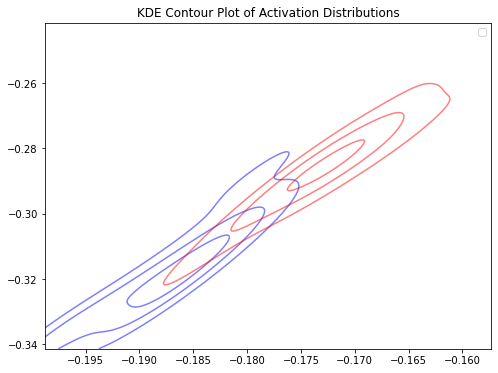

In [18]:
# Create KDE contour plots
plt.figure(figsize=(8, 6))



# Get plot bounds from all activation arrays






['ConA', 'WGA', 'BabA']
['control_1', 'control_2', 'control_3', 'control_4', 'control_5', 'control_6', 'control_7', 'control_8', 'control_9', 'control_10', 'control_11', 'control_12', 'control_13', 'control_14', 'control_15', 'control_16', 'control_17', 'control_18', 'control_19', 'control_20']
['tumor_1', 'tumor_2', 'tumor_3', 'tumor_4', 'tumor_5', 'tumor_6', 'tumor_7', 'tumor_8', 'tumor_9', 'tumor_10', 'tumor_11', 'tumor_12', 'tumor_13', 'tumor_14', 'tumor_15', 'tumor_16', 'tumor_17', 'tumor_18', 'tumor_19', 'tumor_20']


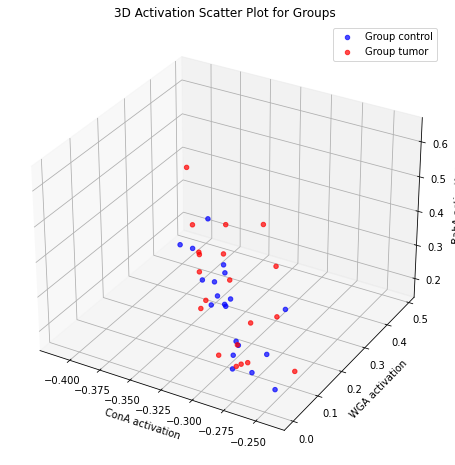

In [131]:
from mpl_toolkits.mplot3d import Axes3D

prot_1 = "ConA"
prot_2 = "WGA"
prot_3 = "BabA"

prot_names = [prot_1, prot_2, prot_3]
print(prot_names)
prot_seq_list = build_prot_seq_list(prot_names)

z_score_mat = build_z_score_mat(glycans_in_df, prot_seq_list, emb, use_emb = True, force_nearest = False, no_nan = True)
activation_arrays = build_activation_arrays(z_score_mat, group_indices, df)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed

for i, (group, activation_array) in enumerate(activation_arrays.items()):
    # Make sure there are at least 3 proteins (rows)
    if activation_array.shape[0] < 3:
        continue
    ax.scatter(
        activation_array[0, :],  # x: first protein
        activation_array[1, :],  # y: second protein
        activation_array[2, :],  # z: third protein
        color=colors[i % len(colors)],
        label=f'Group {group}',
        alpha=0.7
    )

ax.set_xlabel(f'{prot_names[0]} activation')
ax.set_ylabel(f'{prot_names[1]} activation')
ax.set_zlabel(f'{prot_names[2]} activation')
ax.set_title('3D Activation Scatter Plot for Groups')
ax.legend()
plt.show()

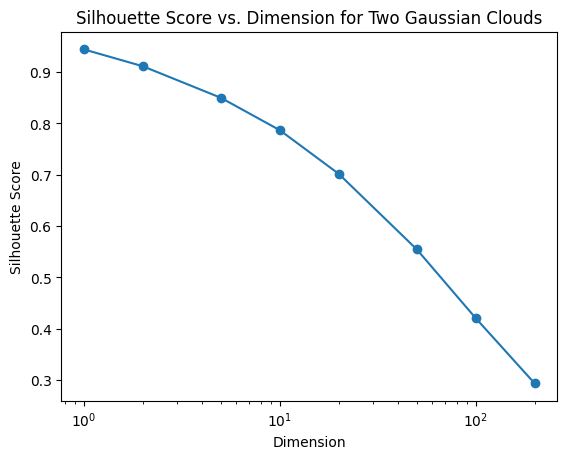

0.19723657826673746


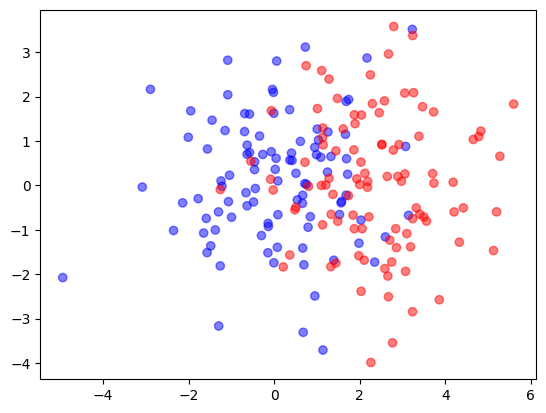

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

def silhouette_vs_dimension(
    n_samples=200,
    dims=[2, 5, 10, 20, 50, 100, 200],
    var1=1.0,
    var2=1.0,
    mean_sep=5.0,
    n_trials=5,
    random_state=None
):
    if random_state is not None:
        np.random.seed(random_state)
    scores = []
    for d in dims:
        trial_scores = []
        for _ in range(n_trials):
            n1 = n_samples // 2
            n2 = n_samples - n1
            mean1 = np.zeros(d)
            mean2 = np.zeros(d)
            mean2[0] = mean_sep  # separate along first axis
            X1 = np.random.normal(loc=mean1, scale=np.sqrt(var1), size=(n1, d))
            X2 = np.random.normal(loc=mean2, scale=np.sqrt(var2), size=(n2, d))
            X = np.vstack([X1, X2])
            labels = np.array([0]*n1 + [1]*n2)
            score = silhouette_score(X, labels)
            trial_scores.append(score)
        scores.append((np.mean(trial_scores), np.std(trial_scores)))
    mean_scores = [s[0] for s in scores]
    std_scores = [s[1] for s in scores]
    return dims, mean_scores, std_scores

# Example usage:
dims, mean_scores, std_scores = silhouette_vs_dimension(
    n_samples=200, dims=[1, 2, 5, 10, 20, 50, 100, 200], var1=1.0, var2=1.0, mean_sep=20.0, n_trials=10, random_state=42
)

plt.errorbar(dims, mean_scores, yerr=std_scores, fmt='-o')
plt.xlabel('Dimension')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Dimension for Two Gaussian Clouds')
plt.xscale('log')
plt.show()

n_samples = 200
mean_sep = 2.5
d = 2
var1 = 2e0
var2 = 2e0

n1 = n_samples // 2
n2 = n_samples - n1
mean1 = np.zeros(d)
mean2 = np.zeros(d)
mean2[0] = mean_sep  # separate along first axis
X1 = np.random.normal(loc=mean1, scale=np.sqrt(var1), size=(n1, d))
X2 = np.random.normal(loc=mean2, scale=np.sqrt(var2), size=(n2, d))
X = np.vstack([X1, X2])
labels = np.array([0]*n1 + [1]*n2)
score = silhouette_score(X, labels)
print(score)

plt.scatter(X[:,0], X[:,1], c=labels, cmap='bwr', alpha=0.5)
plt.show()



In [ ]:

np.random.seed(12987529)
a0 = np.array([100, 299, 100])
D0 = np.random.dirichlet(a0, 1000)
logl0 = dirichlet_mle.loglikelihood(D0, a0)

# D0a = np.random.dirichlet(a0, 1000)
# logl0a = dirichlet_mle.loglikelihood(D0a, a0)

# a1 = np.array([50, 50, 90])
# D1 = np.random.dirichlet(a1, 1000)
# logl1 = dirichlet_mle.loglikelihood(D1, a1)

#@pytest.mark.parametrize("method", ["fixedpoint", "meanprecision"])
method = "fixedpoint"
a0_fit = dirichlet_mle.mle(D0, method=method)
logl0_fit = dirichlet_mle.loglikelihood(D0, a0_fit)
print(D0)
print(np.linalg.norm(a0 - a0_fit) / np.linalg.norm(a0) < 0.1)
print(abs((logl0_fit - logl0) / logl0_fit) < 0.01)